# Submissions anlysis

In [57]:
%matplotlib inline

import os
import sys
# Include directory for own modules
module_path = os.path.abspath(os.path.join('../../code/own_modules'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import itertools
import cem
import imp
from concentration_library import gini
from scipy.stats import mannwhitneyu, wilcoxon, ttest_ind, ttest_1samp
from matplotlib import cm
import matplotlib.gridspec as gridspec

DATA_DIR = '../../data/'

sns.set(style="ticks", palette="bright", context='paper', 
        rc={"lines.linewidth": 0.25, 'axes.linewidth':0.25, 
            'xtick.major.size': 2, 'xtick.major.width':0.25, 'xtick.labelsize': 6,
            'ytick.major.size': 2, 'ytick.major.width':0.25, 'ytick.labelsize': 6,
            'legend.fontsize': 6, 'font.size': 6})

mpl.rcParams['font.size'] = 6
mpl.rcParams['axes.titlesize'] = 8
mpl.rcParams['axes.labelsize'] = 8
mpl.rcParams['xtick.labelsize'] = 6
mpl.rcParams['ytick.labelsize'] = 6
mpl.rcParams['legend.fontsize'] = 6
mpl.rcParams['axes.linewidth'] = 0.25
mpl.rcParams['xtick.major.size'] = 2
mpl.rcParams['ytick.major.width'] = 0.25
mpl.rcParams['ytick.major.size'] = 2
mpl.rcParams['xtick.major.width'] = 0.25
mpl.rcParams['xtick.major.pad']='4'
mpl.rcParams['ytick.major.pad']='4'
mpl.rcParams['xtick.minor.size'] = 2
mpl.rcParams['ytick.minor.width'] = 0.25
mpl.rcParams['ytick.minor.size'] = 2
mpl.rcParams['xtick.minor.width'] = 0.25
#mpl.rcParams['xtick.direction'] = 'out'
#mpl.rcParams['ytick.direction'] = 'out'
mpl.rcParams['lines.linewidth'] = 0.25
mpl.rcParams['patch.linewidth'] = 0.25
mpl.rcParams['lines.markersize'] = 3
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial']

## 0. Get data

In [58]:
def get_submission_data():
    # Concatenate data from separate sheets
    vars = ['equals', 'insertions', \
                'deletions', 'submission_chars', 'submission_lines', 'submission_number']
    df = pd.read_excel(DATA_DIR + 'diffs.xls', sheet_name='coder id and round id')
    for var in vars:
        dfvar = pd.read_excel(DATA_DIR + 'diffs.xls', \
                              sheet_name=var, header=None, names=[var+str(i) for i in range(1, 163)])
        df = pd.concat([df, dfvar], axis=1)
    
    # Drop missing coders
    df = df[(df['round_id'] != 0) & (df['coder_id'] != 0)]
    # Drop first records of 4 coders who switched languages halfway through !!!
    df = df.drop_duplicates(subset = ['round_id', 'coder_id'])
    
    # Trnasform from wide to long
    df = pd.wide_to_long(df, stubnames=vars, i=['round_id', 'coder_id'], j='temp')\
            .reset_index()
    # Drop missing submissions and temp column
    df = df[(df['submission_number'] > 0)]
    df = df.drop(columns=['temp'])
    
    # Recode diffs for submission_number==1 as missing
    df.loc[df['submission_number']==1, ['equals', 'insertions', 'deletions']] = np.nan
    
    # Merge with complexity scores and stratum
    cdf = pd.read_csv('matched_individuals_plus_newcomers_complexity.csv')\
             [['stratum', 'problem_id', 'round_id', 'coder_id', 'language_id', \
               'open_time', 'relative_submit_time', 'submission_point', 'submission_number', 'Tot_Compl']]
    cdf.columns = ['stratum', 'problem_id', 'round_id', 'coder_id', 'language_id', \
               'open_time', 'relative_submit_time', 'submission_point', 'submission_number', 'complexity']
    df = df.merge(cdf, on = ['round_id', 'coder_id', 'submission_number'], how = 'outer')
    df.sort_values(by = ['stratum', 'round_id', 'coder_id', 'submission_number'], inplace = True)
    
    # Get matched round_id and coder_id
    matched_df = pd.read_csv('matched_individuals_plus_newcomers.csv')
    df = df.merge(matched_df, on = ['stratum', 'round_id', 'coder_id'], how = 'right')
    # Export to csv to read from since munging takes some time
    df.to_csv('matched_individuals_plus_newcomers_submissions.csv', index = False)

    return df

# Run once only since it takes a bit of time
#df = get_submission_data()


# Matched individuals

## 0. Get data and export for R analysis

In [59]:
def get_df_with_timing(df):
    # Get latest time submission made in relative terms
    df['registration_time'] = (df['open_time'] - df['first_submission_time']) \
                                                    / (3600 * df['duration'])
    df['submission_time'] = (df['open_time'] + df['relative_submit_time'] \
                                            - df['first_submission_time']) \
                                            / (3600 * df['duration'])

    # Get min submission_time and max submission_time per user
    df['first_submission_time'] = df\
                       .groupby(['round_id', 'coder_id'])['submission_time']\
                       .transform('min')
    df['last_submission_time'] = df\
                       .groupby(['round_id', 'coder_id'])['submission_time']\
                       .transform('max')
    df['length_submission_period'] = df['last_submission_time'] - df['first_submission_time']
    return df

def get_df_with_summary_stats(df):
    # Get first, mean, and last of submission variables
    df.sort_values(by = ['round_id', 'coder_id', 'submission_number'], inplace = True)
    
    first = df.groupby(['round_id', 'coder_id'])['complexity'].first()
    last = df.groupby(['round_id', 'coder_id'])['complexity']\
                     .apply( lambda x: get_last(x) )
    
    new = pd.concat([first, last], axis=1)
    new.columns = ['first_complexity_est', 'last_complexity_est']
    new.reset_index(inplace=True)
    
    df = df.merge(new, on = ['round_id', 'coder_id'], how = 'left')
        
    return df

def get_last(x):
    '''Get the last non-missing value.'''
    i = -1
    y = x.iloc[i]
    while np.isnan(y) and abs(i) < len(x):
        i -= 1
        y = x.iloc[i]
    return y

    

# Get submissions data
sub_df = pd.read_csv('matched_individuals_plus_newcomers_submissions.csv')
matched_ind_df = pd.read_csv('individuals_matched.csv')
print(matched_ind_df.head())

# Restrict to matched individuals only
matched_sub_df = matched_ind_df\
                 .merge(sub_df, on=['stratum', 'round_id', 'coder_id'], how='left')
matched_sub_df = get_df_with_timing(matched_sub_df)
matched_sub_df = get_df_with_summary_stats(matched_sub_df)

# Leave one record per challenge-individual for descriptive analysis of individuals
matched_ind_df = matched_sub_df.drop_duplicates(subset = ['stratum', 'round_id', 'coder_id'])
matched_ind_df = matched_ind_df.drop(columns = ['open_time', \
                'relative_submit_time', 'submission_point', 'submission_number',\
                 'equals', 'insertions', 'deletions', 'submission_lines', 'complexity'])
# Export data
matched_ind_df.to_csv('individuals_matched_sub_stats.csv', index = False) 


   round_id  coder_id      handle attended  num_submissions  point_total  \
0     13565   7213681      wleite        Y                3        77.00   
1     12198   7213681      wleite        Y                6        67.94   
2     12200   7213681      wleite        Y                3        92.26   
3     13565   7527926  Softwalker        Y                1        33.00   
4     12200   7527926  Softwalker        Y                4        15.70   

   provisional_placed  system_point_total  placed  rated_ind  ...  \
0                 3.0              389.00     1.0          1  ...   
1                 9.0              758.92     9.0          1  ...   
2                 7.0              459.66     6.0          1  ...   
3                23.0              161.00    24.0          1  ...   
4                24.0               75.87    24.0          1  ...   

   contestant_registrant_ratio  average_experience  engagement_barrier  \
0                     0.423810            5.674157    

## 1. Timing of submissions

(1232, 66)
(954, 5)


/Users/tsvetkom/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(954, 5)
(954, 5)
(864, 5)
                                     sum_code_lines
old_rating_rank_decile scoring_type                
0.0                    Absolute          357.933333
                       Relative          112.650000
0.1                    Absolute          492.848485
                       Relative          446.690909
0.2                    Absolute          700.605263
                       Relative          518.961111
0.3                    Absolute          725.125000
                       Relative          668.608333
0.4                    Absolute          833.313953
                       Relative          709.701515
0.5                    Absolute          788.237374
                       Relative          884.151316
0.6                    Absolute          997.916667
                       Relative         1127.975347
0.7                    Absolute          946.600000
                       Relative         1098.855903
0.8                    Absolute      

/var/folders/6z/6rb5shzx795cjdd60ph6_5300000gn/T/ipykernel_9405/1944349100.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/6z/6rb5shzx795cjdd60ph6_5300000gn/T/ipykernel_9405/1944349100.py:56: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "type" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('plots/fig_1.pdf', type='pdf')


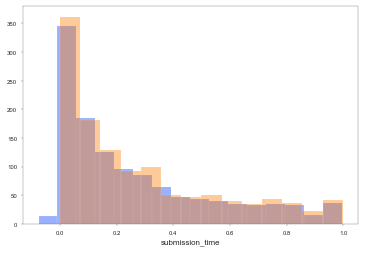

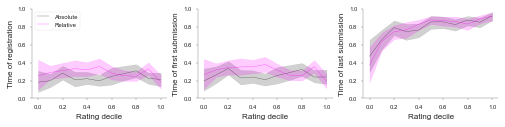

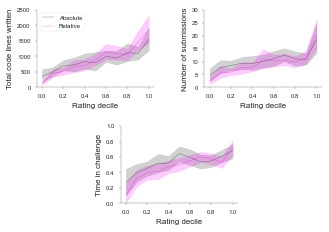

In [60]:
def plot_indiv_mean_stratum_val_by_rating(df, ax, y, yname, ylim, 
                                          legend=False, loc='best', print_summary=False):
    mean_df = df.groupby(['stratum', 'coder_id', 'scoring_type'])[['old_rating_rank_norm', y]].mean().reset_index()
    print(mean_df.shape)
    mean_df['old_rating_rank_decile'] = mean_df['old_rating_rank_norm'].round(1)
    if print_summary:
        print(mean_df.groupby(['old_rating_rank_decile', 'scoring_type'])[[y]].mean())
    sns.lineplot(x='old_rating_rank_decile', y=y, hue='scoring_type', data=mean_df, ax = ax, palette=['k', 'magenta'])
    ax.set_xlabel('Rating decile', fontsize=8)
    ax.set_ylabel(yname, fontsize=8)
    sns.despine()
    ax.set_ylim(ylim[0],ylim[1])
    if legend==False:
        ax.legend().set_visible(False)
    else:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles=handles, labels=labels, loc=loc) #[1:]
    #ax.grid('on')
    

# Drop missing variable for descriptive analysis of submissions
temp = matched_ind_df[matched_ind_df['registration_time'].notnull()]
print(temp.shape)
# Distribution of registration and submission times
plt.figure()
sns.distplot(temp['registration_time'], kde=False)
sns.distplot(temp['submission_time'], kde=False)


# Plot first submission time, last submission time and time between first and last
# by rating
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (7, 1.75))
plot_indiv_mean_stratum_val_by_rating(matched_ind_df, ax[0], 'registration_time', "Time of registration", (0, 1), legend=True, loc='upper left')
plot_indiv_mean_stratum_val_by_rating(matched_ind_df, ax[1], 'first_submission_time', "Time of first submission", (0, 1))
plot_indiv_mean_stratum_val_by_rating(matched_ind_df, ax[2], 'last_submission_time', "Time of last submission", (0, 1))
plt.tight_layout()


#fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (7, 1.75))
#plot_indiv_mean_stratum_val_by_rating(temp, ax[0], 'registration_time', "Time of registration", (0, 1), legend=True)
#plot_indiv_mean_stratum_val_by_rating(matched_ind_df, ax[0], 'first_submission_time', "Time of first submission", (0, 1), legend=True)
#plot_indiv_mean_stratum_val_by_rating(matched_ind_df, ax[1], 'last_submission_time', "Time of last submission", (0, 1))


fig = plt.figure(figsize = (4.5, 3.2))
gs = gridspec.GridSpec(2, 4, wspace=1.5, hspace=0.5, left=0.1, right=0.98, top=0.95, bottom=0.11)
ax1 = fig.add_subplot(gs[0, :2])
ax2 = fig.add_subplot(gs[0, 2:])
ax3 = fig.add_subplot(gs[1, 1:3])
# Remove 2 outliers with sum_insertions >= 10,000, most likely hard-coded data
matched_ind_df_TMP = matched_ind_df[matched_ind_df['sum_insertions'] < 10000]
plot_indiv_mean_stratum_val_by_rating(matched_ind_df_TMP, ax1, 'sum_code_lines', 'Total code lines written', (0, 2500), legend=True, loc='upper left', print_summary=True)
plot_indiv_mean_stratum_val_by_rating(matched_ind_df, ax2, 'num_submissions', "Number of submissions", (0, 30), print_summary=True)
plot_indiv_mean_stratum_val_by_rating(matched_ind_df, ax3, 'length_submission_period', "Time in challenge", (0, 1), print_summary=True)
plt.tight_layout()
plt.savefig('plots/fig_1.pdf', type='pdf')


## 2. Individual diff trajectories

/var/folders/6z/6rb5shzx795cjdd60ph6_5300000gn/T/ipykernel_9405/861718230.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  grouped = df[df[var].notnull()][df['num_submissions']>9].groupby('scoring_type')
/var/folders/6z/6rb5shzx795cjdd60ph6_5300000gn/T/ipykernel_9405/861718230.py:58: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  temp['scoring_type'].cat.reorder_categories(['Absolute', 'Relative'], inplace = True)
/var/folders/6z/6rb5shzx795cjdd60ph6_5300000gn/T/ipykernel_9405/861718230.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/6z/6rb5shzx795cjdd60ph6_5300000gn/T/ipykernel_9405/861718230.py:83: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "type" which is no lo

Absolute 0.5109479256009105 Ttest_1sampResult(statistic=10.625457549879433, pvalue=1.963494687426934e-09)
Relative 0.5479095747343216 Ttest_1sampResult(statistic=17.185042445579963, pvalue=4.481717523566607e-17)
T-test to compare means Ttest_indResult(statistic=-0.6679435348897271, pvalue=0.5073037271148528)


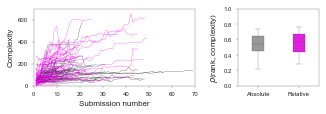

In [61]:
def plot_trajectories_compare(df, var, rolling=False, ylim=(0, 2000)):
    colors = {'Absolute': 'k', 'Relative': 'magenta'}
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 4))
    x = 0
    for lim in [(0, 0.1), (0.95, 1)]:
        grouped = df[(df['old_rating_rank_norm']>=lim[0]) & (df['old_rating_rank_norm']<=lim[1])]\
                  [df[var].notnull()].groupby('scoring_type')
        for name, group in grouped:
            plot_data = group.copy().groupby(['round_id', 'coder_id'])
            for name2, group2 in plot_data:
                subset = group2[['submission_number', var]]
                subset.set_index('submission_number', inplace=True)
                if rolling: 
                    subset.rolling(5).mean().plot(ax = ax[x],
                                                    style='.-',
                                                    color = colors[name],
                                                    legend = False)
                else: 
                    subset.plot(ax = ax[x],
                                style='.-',
                                color = colors[name],
                                legend = False)
        ax[x].set_title(str(lim))  
        ax[x].set_xlim(0, 70)
        ax[x].set_ylim(ylim[0], ylim[1])
        x+=1
        
def plot_trajectories(df, var, ax, ylim=(0, 2000)):
    colors = {'Absolute': 'k', 'Relative': 'magenta'}
    grouped = df[df[var].notnull()][df['num_submissions']>9].groupby('scoring_type')
    for name, group in grouped:  
        to_include = group[['round_id', 'coder_id']].drop_duplicates().sample(n=50, random_state=2)
        plot_data = group.copy().merge(to_include, on=['round_id', 'coder_id'], how='right')\
                                .groupby(['round_id', 'coder_id']) 
        
        for name2, group2 in plot_data:
            subset = group2[['submission_number', var]]
            subset.set_index('submission_number', inplace=True)
            subset.plot(ax = ax,
                            style='-',
                            color = colors[name],
                            legend = False)
        ax.set_ylabel(var.capitalize())  
        ax.set_xlabel('Submission number') 
        ax.set_xlim(0, 70)
        ax.set_ylim(ylim[0], ylim[1])

def boxplot_corrs(df, ax):
    temp1 = df[df['last_complexity'].notnull()]\
              .groupby('round_id')[['prov_rank_norm', 'last_complexity']]\
              .corr(method = 'spearman', min_periods = 8).iloc[0::2, -1]\
              .reset_index(level = 1, drop = True)
    temp2 = df[df['last_complexity'].notnull()]\
              .groupby('round_id')['scoring_type'].first()
    temp = pd.concat([temp2, temp1], axis=1)
    temp.columns = ['scoring_type', 'correlation']
    temp['scoring_type'] = temp['scoring_type'].astype('category')
    temp['scoring_type'].cat.reorder_categories(['Absolute', 'Relative'], inplace = True)
    sns.boxplot(x='scoring_type', y='correlation', data=temp, ax=ax, width=0.3, palette=['0.6', 'magenta'])
    ax.set_ylabel(r"$\rho$(rank, complexity)")  
    ax.set_xlabel('') 
    ax.set_ylim(0,1)
    
    # Print summary statistics
    dfabs = temp[temp['scoring_type']=='Absolute']['correlation'].dropna()
    dfrel = temp[temp['scoring_type']=='Relative']['correlation'].dropna()
    print('Absolute', np.mean(dfabs), ttest_1samp(dfabs, 0.0))
    print('Relative', np.mean(dfrel), ttest_1samp(dfrel, 0.0))
    print('T-test to compare means', ttest_ind(dfabs, dfrel))

# Plot for absolute (black) and relative (magenta) by old_rating_rank_norm
#fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (4.5, 1.75), gridspec_kw={'width_ratios': [2, 1]})
fig = plt.figure(figsize = (4.5, 1.6))
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1], wspace=0.35, left=0.1, right=0.98, top=0.9, bottom=0.23)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

# Correlation of complexity with normalized rank
# Complexity over subsequent submissions
plot_trajectories(matched_sub_df, 'complexity', ax1, ylim = (0, 700))
boxplot_corrs(pd.read_csv('individuals_in_matched_challenges.csv'), ax2)
plt.tight_layout()
plt.savefig('plots/fig_s1.pdf', type='pdf')


## 3. Mean sumission size, diffs, and complexity by rating

/Users/tsvetkom/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


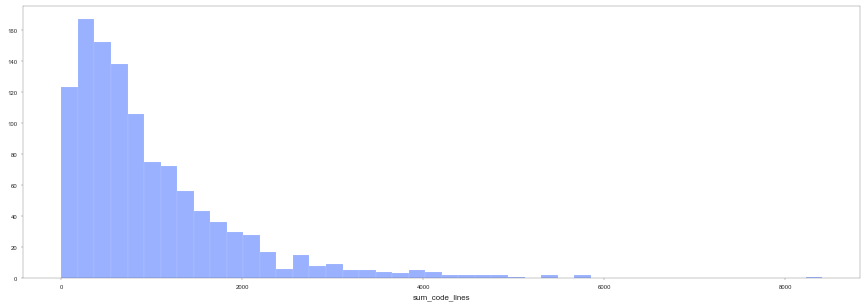

(954, 5)
(954, 5)


/var/folders/6z/6rb5shzx795cjdd60ph6_5300000gn/T/ipykernel_9405/2678136006.py:47: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "type" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('plots/fig_s4.pdf', type='pdf')


(954, 5)
                                     last_complexity
old_rating_rank_decile scoring_type                 
0.0                    Absolute            49.266667
                       Relative            32.980769
0.1                    Absolute            62.787879
                       Relative            97.749524
0.2                    Absolute            86.227273
                       Relative            91.212821
0.3                    Absolute            84.969697
                       Relative           108.649510
0.4                    Absolute           105.030000
                       Relative           122.160227
0.5                    Absolute            93.569820
                       Relative           134.048750
0.6                    Absolute           135.589744
                       Relative           166.979333
0.7                    Absolute           111.814815
                       Relative           186.246000
0.8                    Absolute      

/var/folders/6z/6rb5shzx795cjdd60ph6_5300000gn/T/ipykernel_9405/2678136006.py:55: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "type" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('plots/fig_2.pdf', type='pdf')


(954, 5)
(954, 5)


/var/folders/6z/6rb5shzx795cjdd60ph6_5300000gn/T/ipykernel_9405/2678136006.py:63: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "type" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('plots/fig_2_v2.pdf', type='pdf')


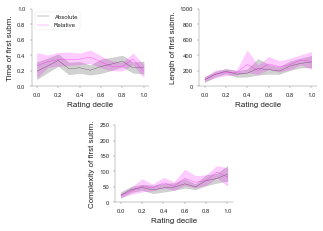

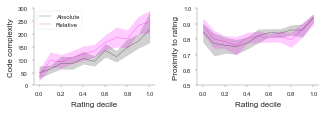

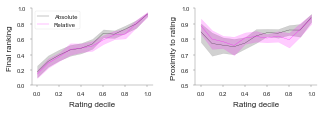

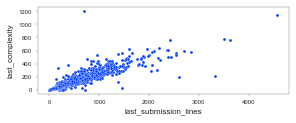

                          sum_code_lines  num_submissions  \
sum_code_lines                  1.000000         0.504448   
num_submissions                 0.504448         1.000000   
length_submission_period        0.462829         0.522267   
last_submission_lines           0.784634         0.220101   
last_complexity                 0.711432         0.208523   

                          length_submission_period  last_submission_lines  \
sum_code_lines                            0.462829               0.784634   
num_submissions                           0.522267               0.220101   
length_submission_period                  1.000000               0.306005   
last_submission_lines                     0.306005               1.000000   
last_complexity                           0.292837               0.878173   

                          last_complexity  
sum_code_lines                   0.711432  
num_submissions                  0.208523  
length_submission_period         0.292

In [62]:
def plot_indiv_aggfunc_stratum_val_by_rating(df, ax, y, yname, ylim, aggfunc = 'mean', legend = False):
    if aggfunc=='mean':
        # Get mean values per coder per contest
        df = df.groupby(['stratum', 'round_id', 'scoring_type', 'coder_id'])[['old_rating_rank_norm', y]].mean().reset_index()
    elif aggfunc=='median':
        # Get mean values per coder per contest
        df = df.groupby(['stratum', 'round_id', 'scoring_type', 'coder_id'])[['old_rating_rank_norm', y]].median().reset_index()
    elif aggfunc=='first':
        # Get first value only
        df = df[df['submission_number']==1][['stratum', 'round_id', 'scoring_type', 'coder_id', 'old_rating_rank_norm', y]]
    elif aggfunc=='max':
        # Get mean values per coder per contest
        df = df.groupby(['stratum', 'round_id', 'scoring_type', 'coder_id'])[['old_rating_rank_norm', y]].max().reset_index()
    
    
    # Get mean for coder by stratum and scoring_type
    mean_df = df.groupby(['stratum', 'coder_id', 'scoring_type'])[['old_rating_rank_norm', y]].mean().reset_index()
    mean_df['old_rating_rank_decile'] = mean_df['old_rating_rank_norm'].round(1)
    sns.lineplot(x='old_rating_rank_decile', y=y, hue='scoring_type', data=mean_df, ax = ax, palette=['k', 'magenta'])
    ax.set_xlabel('Rating decile', fontsize=8)
    ax.set_ylabel(yname, fontsize=8)
    sns.despine()
    ax.set_ylim(ylim[0],ylim[1])
    if legend==False:
        ax.legend().set_visible(False)
    else:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles=handles, labels=labels) #[1:]
    #ax.grid('on')

# Remove 2 outliers with sum_insertions >= 10,000
plt.figure(figsize = (15, 5))
sns.distplot(matched_ind_df[(matched_ind_df['sum_code_lines'].notnull() )& (matched_ind_df['sum_insertions'] < 10000)]['sum_code_lines'], kde=False)
plt.show()
matched_sub_df_TMP = matched_sub_df[matched_sub_df['sum_insertions'] < 10000]
matched_ind_df_TMP = matched_ind_df[matched_ind_df['sum_insertions'] < 10000]
    
# OUTCOME - Code complexity
fig = plt.figure(figsize = (4.5, 3.2))
gs = gridspec.GridSpec(2, 4, wspace=1.5, hspace=0.5, left=0.1, right=0.98, top=0.95, bottom=0.11)
ax1 = fig.add_subplot(gs[0, :2])
ax2 = fig.add_subplot(gs[0, 2:])
ax3 = fig.add_subplot(gs[1, 1:3])
plot_indiv_mean_stratum_val_by_rating(matched_ind_df, ax1, 'first_submission_time', "Time of first subm.", (0, 1), legend=True, loc='upper left')
plot_indiv_aggfunc_stratum_val_by_rating(matched_sub_df_TMP, ax2, 'submission_lines', "Length of first subm.", (0, 1000), aggfunc = 'first')
plot_indiv_mean_stratum_val_by_rating(matched_ind_df, ax3, 'first_complexity', 'Complexity of first subm.', (0, 250))
plt.savefig('plots/fig_s4.pdf', type='pdf')

fig = plt.figure(figsize = (4.5, 1.6))
gs = gridspec.GridSpec(1, 2, wspace=0.35, left=0.1, right=0.98, top=0.9, bottom=0.23)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
plot_indiv_mean_stratum_val_by_rating(matched_ind_df, ax1, 'last_complexity', 'Code complexity', (0, 300), legend=True, loc='upper left', print_summary=True)
plot_indiv_mean_stratum_val_by_rating(matched_ind_df, ax2, 'predictability_prov', "Proximity to rating", (0.5, 1))
plt.savefig('plots/fig_2.pdf', type='pdf')

fig = plt.figure(figsize = (4.5, 1.6))
gs = gridspec.GridSpec(1, 2, wspace=0.35, left=0.1, right=0.98, top=0.9, bottom=0.23)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
plot_indiv_mean_stratum_val_by_rating(matched_ind_df, ax1, 'fin_rank_norm', 'Final ranking', (0, 1), legend=True, loc='upper left')
plot_indiv_mean_stratum_val_by_rating(matched_ind_df, ax2, 'predictability_prov', "Proximity to rating", (0.5, 1))
plt.savefig('plots/fig_2_v2.pdf', type='pdf')

# Test for correlation between measures of effort and performance
fig = plt.figure(figsize = (4.5, 1.6))
sns.scatterplot(data=matched_ind_df_TMP, x='last_submission_lines', y='last_complexity') 
plt.show()

print(matched_ind_df_TMP[['sum_code_lines', 
                          'num_submissions',
                          'length_submission_period',
                          'last_submission_lines', 
                          'last_complexity']].corr(method = 'pearson', min_periods = 8))

## 4. Downward vs. upward social comparison

(450, 5)
                                     sum_code_lines
old_rating_rank_decile scoring_type                
0.0                    Absolute          409.750000
                       Relative           93.428571
0.1                    Absolute          520.789474
                       Relative          510.750000
0.2                    Absolute          649.937500
                       Relative          728.500000
0.3                    Absolute          689.615385
                       Relative          595.000000
0.4                    Absolute         1009.782609
                       Relative          903.800000
0.5                    Absolute         1001.666667
                       Relative          855.368421
0.6                    Absolute         1181.333333
                       Relative         1063.423077
0.7                    Absolute          903.437500
                       Relative         1343.269231
0.8                    Absolute         1100.160000
   

/var/folders/6z/6rb5shzx795cjdd60ph6_5300000gn/T/ipykernel_9405/1972765898.py:33: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "type" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('plots/fig_s4.pdf', type='pdf')


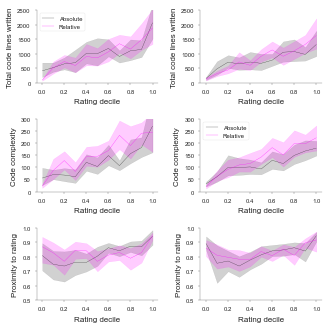

In [70]:
updown_df = pd.read_excel('challenges_matched_instructions.xlsx')[['round_id', 'comparison']]
# Remove 2 outliers with sum_insertions >= 10,000
updown_df = matched_ind_df[matched_ind_df['sum_insertions'] < 10000].merge(updown_df, on='round_id')

# Only upward comparison
matched_ind_df_up = updown_df[updown_df['comparison'] != 'downward']
matched_ind_df_up = matched_ind_df_up.groupby(['stratum', 'coder_id'])\
                                 .filter(lambda x: len(x['scoring_type'].unique()) > 1)\
                                 .reset_index(drop = True)
# Only downward comparison
matched_ind_df_down = updown_df[updown_df['comparison'] != 'upward']
matched_ind_df_down = matched_ind_df_down.groupby(['stratum', 'coder_id'])\
                                 .filter(lambda x: len(x['scoring_type'].unique()) > 1)\
                                 .reset_index(drop = True)

fig = plt.figure(figsize = (4.5, 4.8))
gs = gridspec.GridSpec(3, 2, wspace=0.35, hspace=0.5, left=0.1, right=0.98, top=0.95, bottom=0.11)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
plot_indiv_mean_stratum_val_by_rating(matched_ind_df_down, ax1, 'sum_code_lines', 'Total code lines written', (0, 2500), legend=True, loc='upper left', print_summary=True)
plot_indiv_mean_stratum_val_by_rating(matched_ind_df_up, ax2, 'sum_code_lines', 'Total code lines written', (0, 2500), print_summary=True)

ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
plot_indiv_mean_stratum_val_by_rating(matched_ind_df_down, ax3, 'last_complexity', 'Code complexity', (0, 300))
plot_indiv_mean_stratum_val_by_rating(matched_ind_df_up, ax4, 'last_complexity', 'Code complexity', (0, 300), legend=True, loc='upper left')

ax5 = fig.add_subplot(gs[2, 0])
ax6 = fig.add_subplot(gs[2, 1])
plot_indiv_mean_stratum_val_by_rating(matched_ind_df_down, ax5, 'predictability_prov', "Proximity to rating", (0.5, 1))
plot_indiv_mean_stratum_val_by_rating(matched_ind_df_up, ax6, 'predictability_prov', "Proximity to rating", (0.5, 1))
plt.savefig('plots/fig_s4.pdf', type='pdf')





# Newcomers

## 1. Timing of submissions for newcomers

(1198, 60)


/var/folders/6z/6rb5shzx795cjdd60ph6_5300000gn/T/ipykernel_9405/2694539489.py:69: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "type" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('plots/fig_outcomes_newcom.pdf', type='pdf')
/var/folders/6z/6rb5shzx795cjdd60ph6_5300000gn/T/ipykernel_9405/2694539489.py:81: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "type" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('plots/fig_timing_newcom.pdf', type='pdf')


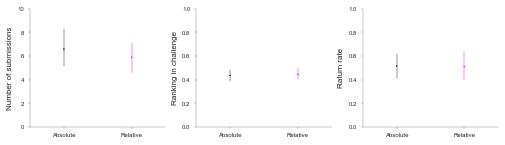

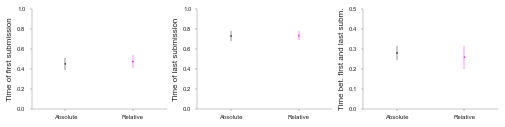

In [64]:
def plot_aggfunc_stratum_val(df, ax, y, yname, ylim, aggfunc = 'mean', legend = False):
    if aggfunc=='mean':
        # Get mean values per coder per contest
        df = df.groupby(['stratum', 'scoring_type', 'coder_id'])[y].mean().reset_index()
    elif aggfunc=='median':
        # Get median values per coder per contest
        df = df.groupby(['stratum', 'scoring_type', 'coder_id'])[y].median().reset_index()
    elif aggfunc=='first':
        # Get first value only
        df = df[df['submission_number']==1][['stratum', 'scoring_type', 'coder_id', y]]
    
    mean_df = df.groupby(['stratum', 'scoring_type'])[y].mean().reset_index()
    # Keep only strata that have both values
    mean_df = mean_df.groupby('stratum').filter(lambda x: x[y].count() == 2)  
    sns.pointplot(x='scoring_type', y=y, data=mean_df, ax = ax, palette=['k', 'magenta'])
    ax.set_xlabel('')
    ax.set_ylabel(yname)
    sns.despine()
    ax.set_ylim(ylim[0], ylim[1])
    

# Import first-timers data (excluding those who are unrated but have 
# particpated in a challenge before) and match with individual-level data
newcom_df = pd.read_csv(DATA_DIR + 'newcomers.csv')[['round_id', 'coder_id', 'ReturnTime']]
newcom_df['returned'] = 0
newcom_df.loc[newcom_df['ReturnTime'].notnull(), 'returned'] = 1

individuals_in_matched_data = pd.read_csv('individuals_in_matched_challenges.csv')
newcom_df = newcom_df[['round_id', 'coder_id', 'returned']] \
                 .merge(individuals_in_matched_data, on=['round_id', 'coder_id'], how='inner')
# Keep only if both control and treatment in stratum
newcom_df = newcom_df[newcom_df.groupby('stratum')['scoring_type']\
                               .transform(lambda x: len(x.unique())) > 1]


# Match with submissions_data
newcom_df = newcom_df\
                 .merge(sub_df, on=['stratum', 'round_id', 'coder_id'], how='left')
newcom_df = get_df_with_timing(newcom_df)
newcom_df = get_df_with_summary_stats(newcom_df)

# Leave one record per challenge-individual for descriptive analysis of individuals
newcom_summ_df = newcom_df.drop_duplicates(subset = ['stratum', 'round_id', 'coder_id'])
newcom_summ_df = newcom_summ_df .drop(columns=['open_time', \
                                     'relative_submit_time', 'submission_point', 'submission_number',\
                                     'equals', 'insertions', 'deletions', 'submission_lines', 'complexity',\
                                    'old_rating', 'old_rating_norm', \
                                    'old_rating_rank_norm', 'predictability_norm_score',\
                                     'new_minus_old_rating', 'dev_from_predicted_prov',\
                                     'dev_from_predicted_fin'])
# Export data 
newcom_summ_df.to_csv('newcomers_matched_sub_stats.csv', index = False)
print(newcom_summ_df.shape)



# Plot outcomes
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (7, 2))
# Outcome
plot_aggfunc_stratum_val(newcom_summ_df, ax[0], 'num_submissions', "Number of submissions", (0, 10))
# Outcome
#plot_aggfunc_stratum_val(newcom_summ_df, ax[1], 'prov_score_norm_distance', "Distance from winner", (0, 1))
plot_aggfunc_stratum_val(newcom_summ_df, ax[1], 'prov_rank_norm', "Ranking in challenge", (0, 1))
# New rating for newcomers
#plot_aggfunc_stratum_val(newcom_summ_df, ax[1], 'new_rating', "New rating", (1000, 1400))
# Percentage newcomers who returned
plot_aggfunc_stratum_val(newcom_summ_df, ax[2], 'returned', "Raturn rate", (0, 1))
plt.tight_layout()
plt.savefig('plots/fig_outcomes_newcom.pdf', type='pdf')

# Plot duration
# Drop missing variable for descriptive analysis of submissions
#temp = newcom_df[newcom_df['registration_time'].notnull()]
#print(temp.shape)
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (7, 1.75))
# Outcome
plot_aggfunc_stratum_val(newcom_summ_df, ax[0], 'first_submission_time', "Time of first submission", (0, 1))
plot_aggfunc_stratum_val(newcom_summ_df, ax[1], 'last_submission_time', "Time of last submission", (0, 1))
plot_aggfunc_stratum_val(newcom_summ_df, ax[2], 'length_submission_period', "Time bet. first and last subm.", (0, 0.5))
plt.tight_layout()
plt.savefig('plots/fig_timing_newcom.pdf', type='pdf')


    

(7810, 76)


/var/folders/6z/6rb5shzx795cjdd60ph6_5300000gn/T/ipykernel_9405/131779572.py:7: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "type" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('plots/fig_code_diffs_newcom.pdf', type='pdf')
/var/folders/6z/6rb5shzx795cjdd60ph6_5300000gn/T/ipykernel_9405/131779572.py:14: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "type" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('plots/fig_code_length_newcom.pdf', type='pdf')
/var/folders/6z/6rb5shzx795cjdd60ph6_5300000gn/T/ipykernel_9405/131779572.py:21: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "type" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('plots/fig_code_complexity_newcom.pdf', type='pdf')


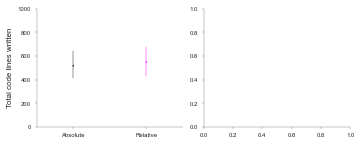

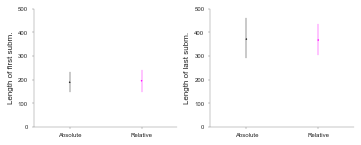

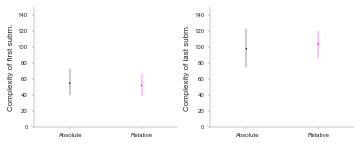

In [65]:
print(newcom_df.shape)

# EFFORT - Code changes
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (5, 2))
plot_aggfunc_stratum_val(newcom_summ_df, ax[0], 'sum_code_lines', 'Total code lines written', (0, 1000))
plt.tight_layout()
plt.savefig('plots/fig_code_diffs_newcom.pdf', type='pdf')

# EFFORT/OUTCOME - Code length
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (5, 2))
plot_aggfunc_stratum_val(newcom_df, ax[0], 'submission_lines', "Length of first subm.", (0, 500), aggfunc = 'first', legend=True)
plot_aggfunc_stratum_val(newcom_df, ax[1], 'submission_lines', "Length of last subm.", (0, 500), aggfunc = 'last')
plt.tight_layout()
plt.savefig('plots/fig_code_length_newcom.pdf', type='pdf')

# OUTCOME - Code complexity
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (5, 2))
plot_aggfunc_stratum_val(newcom_df, ax[0], 'complexity', 'Complexity of first subm.', (0, 150), aggfunc = 'first')
plot_aggfunc_stratum_val(newcom_df, ax[1], 'complexity', 'Complexity of last subm.', (0, 150), aggfunc = 'last')
plt.tight_layout()
plt.savefig('plots/fig_code_complexity_newcom.pdf', type='pdf')
